<a href="https://colab.research.google.com/github/BrajanNieto/Tareas_Programacion101_BrajanNieto/blob/main/01_P3_ButterflyClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Proyecto de clasificación 'Butterfly Image Classification with PyTorch neural networks'
 ----
  
  University : UTEC \\
  Course       : Machine Learning \\
  Professor    : Cristian López Del Alamo \\
  Topic        : SVM \\
  Deadline      : 18-08-2025
   

 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1: Lopez Medina Sebastian 100%
 - Integrante 2: Nieto Espinoza Brajan Esteban 100%
 - Integrante 3: Tapia Chasquibol Mateo 100%

 ----
 The objective of this project is to classify butterflies .

In [1]:
# ============================================
# 0. Insttalaciones
# ============================================
%pip -q install kagglehub scikit-learn pandas matplotlib seaborn pillow

In [41]:
# ============================================
# 1. Librerías
# ============================================

# --- librerías estándar ---
import os, glob, math, random, time, itertools
from pathlib import Path
from typing import List, Tuple, Dict
from itertools import product
from typing import Optional
# ------------- librerías comunes ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display

# --- PyTorch ----- torchvision ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# --- Kaggle (descarga de datos) ---
import kagglehub


# --- Info de paquetes ---
print("PyTorch:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)


PyTorch: 2.6.0+cu124
CUDA disponible: False
NumPy: 2.0.2
Pandas: 2.2.2
Matplotlib: 3.10.0
Seaborn: 0.13.2


In [14]:
# ========================================================
# 2. Carga de datos, reproducibilidad, plotar imagenes
# ========================================================
# Descargar
path = kagglehub.dataset_download("veeralakrishna/butterfly-dataset")
print("Descargado en:", path)
DATA_ROOT = Path(path) / "leedsbutterfly"
print("DATA_ROOT:", DATA_ROOT)
# ver estructura
!find "$DATA_ROOT" -maxdepth 2 -type d | sed 's|^|DIR: |'

# -------------------------
# Reproducibilidad
# -------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Descargado en: /kaggle/input/butterfly-dataset
DATA_ROOT: /kaggle/input/butterfly-dataset/leedsbutterfly
DIR: /kaggle/input/butterfly-dataset/leedsbutterfly
DIR: /kaggle/input/butterfly-dataset/leedsbutterfly/images
DIR: /kaggle/input/butterfly-dataset/leedsbutterfly/segmentations
DIR: /kaggle/input/butterfly-dataset/leedsbutterfly/descriptions


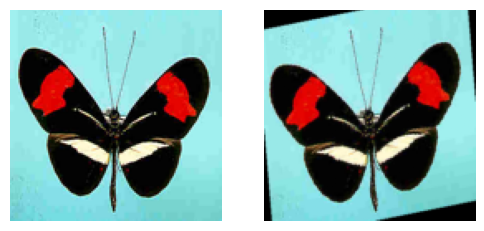

In [19]:
# ========================================================
# 3. Dataset y transforms
# ========================================================

def list_png_labels(root: Path) -> Tuple[List[Tuple[str, int]], List[str]]:
    paths = sorted([p for p in Path(root).iterdir() if p.is_file() and p.suffix.lower() == ".png"])
    prefixes = sorted({p.name[:3] for p in paths})
    prefix_to_idx = {pref: i for i, pref in enumerate(prefixes)}
    samples = [(str(p), prefix_to_idx[p.name[:3]]) for p in paths]
    return samples, prefixes

class FileListDataset(Dataset):
    """Dataset simple para (ruta, etiqueta) en carpeta plana."""
    def __init__(self, items: List[Tuple[str, int]], transform=None):
        self.items = items
        self.transform = transform
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        path, label = self.items[idx]
        with PILImage.open(path) as img:
            img = img.convert("RGB")
            if self.transform:
                img = self.transform(img)
        return img, label

def build_transforms(img_size: int = 64,
                     normalize: bool = True,
                     augment: bool = True,
                     for_mlp: bool = False):
    norm = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                               std=(0.229, 0.224, 0.225)) if normalize else transforms.Lambda(lambda x: x)
    aug = [transforms.RandomHorizontalFlip(p=0.5),
           transforms.RandomRotation(degrees=10)] if augment else []
    common = [transforms.Resize((img_size, img_size)), transforms.ToTensor(), norm]
    if for_mlp:
        common.append(transforms.Lambda(lambda t: t.view(-1)))  # aplanar a vector
    train_tf = transforms.Compose(aug + common)
    eval_tf  = transforms.Compose(common)
    return train_tf, eval_tf, eval_tf

# -------------------------
# Prueba original vs transformada
# -------------------------
p = DATA_ROOT / "images" / "0030060.png"
orig = PILImage.open(p).convert("RGB")
x = build_transforms(img_size=128, normalize=False, augment=True, for_mlp=False)[0](orig)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.axis("off"); plt.imshow(orig.resize((128,128)))
plt.subplot(1,2,2); plt.axis("off"); plt.imshow(x.permute(1,2,0).numpy())
plt.show()

In [23]:
# ========================================================
# 4. Modelos: MLP y CNN
# ========================================================

class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_sizes: List[int],
                 num_classes: int, activation: str = "relu",
                 dropout: float = 0.0):
        super().__init__()
        act = {"relu": nn.ReLU, "tanh": nn.Tanh, "sigmoid": nn.Sigmoid}
        if activation not in act: raise ValueError(f"Unsupported activation: {activation}")
        Act = act[activation]
        layers: List[nn.Module] = []
        prev = input_dim
        for h in hidden_sizes:
            layers.extend([nn.Linear(prev, h), Act()])
            if dropout > 0: layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

class SimpleCNN(nn.Module):
    """Asume img_size=64 → tras dos MaxPool2d(2) queda 16x16."""
    def __init__(self, num_classes: int, in_channels: int = 3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),        nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )
    def forward(self, x): return self.classifier(self.features(x))


# -------------------------
# Prueba mínima (misma imagen → shapes de logits)
# -------------------------
K = len(list_png_labels(DATA_ROOT / "images")[1])
p = DATA_ROOT / "images" / "0030060.png"
img = PILImage.open(p).convert("RGB")
# Vector para MLP
x_vec_ = build_transforms(64, normalize=False, augment=False, for_mlp=True)[0](img)   # [3*64*64]
print("x_vec shape:", tuple(x_vec_.shape), "| primeros 8:", x_vec_[:8].tolist())
# Tensor imagen para CNN
x_img_ = build_transforms(64, normalize=False, augment=False, for_mlp=False)[0](img)  # [3,64,64]
print("x_img shape:", tuple(x_img_.shape),
      "| patch[ :,0:2,0:2 ]:\n", x_img_[:, :2, :2],
      "\nmin/max/mean:", float(x_img_.min()), float(x_img_.max()), float(x_img_.mean()))

x_vec = x_vec_.unsqueeze(0)  # [1, 3*64*64]
x_img = x_img_.unsqueeze(0)  # [1, 3, 64, 64]

# ---------- Modelos ----------
mlp = MLP(input_dim=x_vec.shape[1], hidden_sizes=[128, 64], num_classes=K)
cnn = SimpleCNN(num_classes=K)
mlp.eval(); cnn.eval()

# ---------- Hooks ----------
hooks = []
def mk_hook(tag):
    def _hook(m, inp, out):
        t = out[0] if isinstance(out, (list, tuple)) else out
        print(f"[{tag}] shape={tuple(t.shape)} | mean={float(t.mean()):.4f} std={float(t.std()):.4f}")
    return _hook
for i, m in enumerate(mlp.net):
    hooks.append(m.register_forward_hook(mk_hook(f"MLP {i}:{m.__class__.__name__}")))
for i, m in enumerate(cnn.features):
    hooks.append(m.register_forward_hook(mk_hook(f"CNN-feat {i}:{m.__class__.__name__}")))
for i, m in enumerate(cnn.classifier):
    hooks.append(m.register_forward_hook(mk_hook(f"CNN-cls {i}:{m.__class__.__name__}")))
# --------------------
with torch.no_grad():
    print("\n>>> Forward MLP")
    y_mlp = mlp(x_vec)   # [1,K]
    print("MLP logits:", tuple(y_mlp.shape), ":", y_mlp[0, :min(10, K)].tolist())
    print("\n>>> Forward CNN")
    y_cnn = cnn(x_img)   # [1,K]
    print("CNN logits:", tuple(y_cnn.shape), ":", y_cnn[0, :min(10, K)].tolist())

x_vec shape: (12288,) | primeros 8: [0.6274510025978088, 0.6274510025978088, 0.6117647290229797, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.5882353186607361]
x_img shape: (3, 64, 64) | patch[ :,0:2,0:2 ]:
 tensor([[[0.6275, 0.6275],
         [0.6275, 0.6275]],

        [[0.9412, 0.9412],
         [0.9412, 0.9412]],

        [[0.9373, 0.9373],
         [0.9373, 0.9373]]]) 
min/max/mean: 0.0 1.0 0.5521376132965088

>>> Forward MLP
[MLP 0:Linear] shape=(1, 128) | mean=0.0081 std=0.3784
[MLP 1:ReLU] shape=(1, 128) | mean=0.1582 std=0.2218
[MLP 2:Linear] shape=(1, 64) | mean=0.0062 std=0.1634
[MLP 3:ReLU] shape=(1, 64) | mean=0.0676 std=0.0932
[MLP 4:Linear] shape=(1, 10) | mean=-0.0743 std=0.0787
MLP logits: (1, 10) : [-0.09908461570739746, -0.07441257685422897, -0.15097244083881378, -0.17179057002067566, -0.044248517602682114, 0.06178893893957138, -0.048163168132305145, -0.05611025169491768, -0.1780306100845337, 0.018313199281692505]

>>> Forward CNN

In [42]:
# ========================================================
# 4. Entrenamiento / evaluación / métricas
# ========================================================

# -------------------------
# compute_metrics — Métricas agregadas (accuracy, macro/weighted F1)
# -------------------------
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    """Devuelve métricas agregadas: accuracy, macro-precision/recall/F1, weighted-F1."""
    acc = accuracy_score(y_true, y_pred)
    prec_m = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_m  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_m   = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_w   = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return {"accuracy": acc, "precision_macro": prec_m, "recall_macro": rec_m,
            "f1_macro": f1_m, "f1_weighted": f1_w}

# -------------------------
# train_one_epoch — Entrenamiento de una época (loss y acc)
# -------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Entrena 1 época y devuelve (loss_promedio, accuracy_promedio)."""
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); optimizer.step()
        loss_sum += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return loss_sum / total, correct / total

# -------------------------
# evaluate — Evaluación (loss, acc y vectores y_true/y_pred)
# -------------------------
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evalúa y devuelve (loss_prom, acc_prom, y_true, y_pred)."""
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    y_true, y_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        y_true.extend(yb.tolist()); y_pred.extend(preds.tolist())
    return loss_sum / total, correct / total, np.array(y_true), np.array(y_pred)

# -------------------------
# plot_curves — Guardar curvas de pérdida y accuracy
# -------------------------
def plot_curves(history: Dict[str, List[float]], title: str, out_png: Path):
    """Guarda dos PNG: curvas de pérdida y de accuracy por época."""
    base = Path(out_png); base.parent.mkdir(parents=True, exist_ok=True)
    loss_path = base.with_name(f"{base.stem}_loss.png")
    acc_path  = base.with_name(f"{base.stem}_acc.png")
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} - Loss")
    plt.legend(); plt.tight_layout(); plt.savefig(loss_path, dpi=150); plt.close()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"],   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} - Accuracy")
    plt.legend(); plt.tight_layout(); plt.savefig(acc_path, dpi=150); plt.close()

# -------------------------
# save_confusion_matrix — (impresión) Matriz de confusión en tabla (sin gráfico)
# -------------------------

def print_confusion_matrix(y_true, y_pred, class_names, title: str, out_png: Optional[Path] = None):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                         columns=[f"pred_{c}" for c in class_names])
    print(f"\n{title} — Matriz de confusión")
    print(df.to_string())
    return cm, df

In [43]:
# ========================================================
# 5. Runner de entrenamiento / evaluación (con save_artifacts opcional)
# ========================================================
def run_experiment(
    data_root: Path, img_size: int, batch_size: int, epochs: int,
    lr: float, optimizer_name: str, augment: bool, activation: str,
    hidden_sizes: List[int], dropout: float, model_type: str,
    num_workers: int, seed: int, device_str: str = None,
    save_artifacts: bool = False  # <-- NUEVO: opcional
):
    set_seed(seed)
    device = torch.device(device_str) if device_str else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pin = (device.type == "cuda")
    print(f"[Device] {device} | CUDA avail={torch.cuda.is_available()}")

    # Datos (asumimos .../images)
    root_images = Path(data_root) / "images"
    samples, class_names = list_png_labels(root_images)
    num_classes = len(class_names)
    print(f"[Data] imgs={len(samples)} | clases={num_classes} | img_size={img_size} | augment={augment}")

    # Split 80/10/10
    paths  = [p for p, y in samples]
    labels = [y for _, y in samples]
    tr_paths, tmp_paths, tr_y, tmp_y = train_test_split(paths, labels, test_size=0.2, random_state=seed, stratify=labels)
    va_paths, te_paths, va_y, te_y   = train_test_split(tmp_paths, tmp_y, test_size=0.5, random_state=seed, stratify=tmp_y)
    print(f"[Split] train={len(tr_paths)} | val={len(va_paths)} | test={len(te_paths)} | batch_size={batch_size}")

    # Transforms / Datasets / Loaders
    if model_type.lower() == "mlp":
        tf_tr, tf_va, tf_te = build_transforms(img_size, normalize=True, augment=augment, for_mlp=True)
        input_dim = 3 * img_size * img_size
    else:
        tf_tr, tf_va, tf_te = build_transforms(img_size, normalize=True, augment=augment, for_mlp=False)
        input_dim = None

    ds_tr = FileListDataset(list(zip(tr_paths, tr_y)), transform=tf_tr)
    ds_va = FileListDataset(list(zip(va_paths, va_y)), transform=tf_va)
    ds_te = FileListDataset(list(zip(te_paths, te_y)), transform=tf_te)

    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=pin)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin)

    # Modelo
    if model_type.lower() == "mlp":
        model = MLP(input_dim=input_dim,
                    hidden_sizes=hidden_sizes if hidden_sizes else [1024, 512],
                    num_classes=num_classes, activation=activation, dropout=dropout)
        title = f"MLP_{activation}_hs{hidden_sizes if hidden_sizes else [1024,512]}_do{dropout}"
    else:
        model = SimpleCNN(num_classes=num_classes)
        title = "SimpleCNN"
    model = model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    opt_name = optimizer_name.lower()
    if opt_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        opt_desc = f"Adam(lr={lr})"
    elif opt_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        opt_desc = f"SGD(lr={lr}, momentum=0.9)"
    else:
        raise ValueError("optimizer must be 'adam' or 'sgd'")
    print(f"[Model] {title} | optimizer={opt_desc} | dropout={dropout} | activation={activation if model_type.lower()=='mlp' else 'ReLU(fija)'}")

    # Entrenamiento
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val_f1, best_state = -1.0, None
    t0 = time.perf_counter()
    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, dl_tr, criterion, optimizer, device)
        va_loss, va_acc, y_val, p_val = evaluate(model, dl_va, criterion, device)
        f1_m = f1_score(y_val, p_val, average='macro', zero_division=0)

        history["train_loss"].append(tr_loss); history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)

        if f1_m > best_val_f1:
            best_val_f1 = f1_m
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"[{title}] Ep {epoch:02d}/{epochs} | Train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
              f"Val loss {va_loss:.4f} acc {va_acc:.3f} F1(macro) {f1_m:.3f}")

    elapsed = (time.perf_counter() - t0) / max(1, epochs)
    print(f"[Tiempo] ~{elapsed:.2f}s/epoch | best Val F1(macro)={best_val_f1:.3f}")

    # Test (mejor estado)
    if best_state is not None:
        model.load_state_dict(best_state)
    _, _, y_test, p_test = evaluate(model, dl_te, criterion, device)
    test_metrics = compute_metrics(y_test, p_test)
    print(f"[Test] acc={test_metrics['accuracy']:.3f} | F1(macro)={test_metrics['f1_macro']:.3f} | F1(weighted)={test_metrics['f1_weighted']:.3f}")

    # Salidas en consola
    print_confusion_matrix(y_test, p_test, class_names, f"{title} - Confusion Matrix")
    print("\n[Classification report]")
    print(classification_report(
        y_test, p_test, labels=list(range(num_classes)),
        target_names=class_names, digits=3, zero_division=0
    ))

    # Guardados opcionales
    if save_artifacts:
        out_dir = Path("outputs"); out_dir.mkdir(parents=True, exist_ok=True)
        plot_curves(history, title, out_dir / f"{title}.png")
        report_dict = classification_report(
            y_test, p_test,
            labels=list(range(num_classes)),
            target_names=class_names,
            output_dict=True, zero_division=0
        )
        pd.DataFrame(report_dict).to_csv(out_dir / f"{title}_classification_report.csv", index=True)

    return {
        "model_type": model_type,
        "model": title,
        "optimizer": optimizer.__class__.__name__,
        "lr": lr,
        "dropout": dropout if model_type.lower()=="mlp" else None,
        "activation": activation if model_type.lower()=="mlp" else "relu",
        "img_size": img_size,
        "batch_size": batch_size,
        "epochs": epochs,
        "time_per_epoch_sec": elapsed,
        "n_train": len(ds_tr), "n_val": len(ds_va), "n_test": len(ds_te),
        "accuracy": test_metrics["accuracy"],
        "precision_macro": test_metrics["precision_macro"],
        "recall_macro": test_metrics["recall_macro"],
        "f1_macro": test_metrics["f1_macro"],
        "f1_weighted": test_metrics["f1_weighted"],
        "classes": class_names
    }

In [44]:
# ====== MLP (prueba rápida CPU) ======
mlp_summary = run_experiment(
    data_root=Path(DATA_ROOT),
    img_size=64,
    batch_size=32,
    epochs=8,
    lr=1e-3,
    optimizer_name="adam",
    augment=True,
    activation="relu",
    hidden_sizes=[512, 256],
    dropout=0.0,
    model_type="mlp",
    num_workers=0,
    seed=42,
    device_str="cpu"      # Fuerza CPU; si quieres auto, quita este argumento
)
pd.DataFrame([mlp_summary])


[Device] cpu | CUDA avail=False
[Data] imgs=832 | clases=10 | img_size=64 | augment=True
[Split] train=665 | val=83 | test=84 | batch_size=32
[Model] MLP_relu_hs[512, 256]_do0.0 | optimizer=Adam(lr=0.001) | dropout=0.0 | activation=relu
[MLP_relu_hs[512, 256]_do0.0] Ep 01/8 | Train loss 2.6195 acc 0.271 | Val loss 1.9116 acc 0.373 F1(macro) 0.337
[MLP_relu_hs[512, 256]_do0.0] Ep 02/8 | Train loss 1.7287 acc 0.415 | Val loss 1.7912 acc 0.349 F1(macro) 0.361
[MLP_relu_hs[512, 256]_do0.0] Ep 03/8 | Train loss 1.3750 acc 0.516 | Val loss 1.6496 acc 0.458 F1(macro) 0.472
[MLP_relu_hs[512, 256]_do0.0] Ep 04/8 | Train loss 1.2101 acc 0.591 | Val loss 1.6073 acc 0.422 F1(macro) 0.433
[MLP_relu_hs[512, 256]_do0.0] Ep 05/8 | Train loss 1.1502 acc 0.627 | Val loss 1.6434 acc 0.422 F1(macro) 0.439
[MLP_relu_hs[512, 256]_do0.0] Ep 06/8 | Train loss 0.9527 acc 0.665 | Val loss 1.4961 acc 0.506 F1(macro) 0.514
[MLP_relu_hs[512, 256]_do0.0] Ep 07/8 | Train loss 0.8142 acc 0.741 | Val loss 1.6161 acc 0

,model_type,model,optimizer,lr,dropout,activation,img_size,batch_size,epochs,time_per_epoch_sec,n_train,n_val,n_test,accuracy,precision_macro,recall_macro,f1_macro,f1_weighted,classes
0,mlp,"MLP_relu_hs[512, 256]_do0.0",Adam,0.001,0.0,relu,64,32,8,20.146462,665,83,84,0.452381,0.479545,0.469444,0.455051,0.44771,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ..."


In [45]:
# ====== CNN (mismo tamaño 64x64) ======
cnn_summary = run_experiment(
    data_root=Path(DATA_ROOT),
    img_size=64,          # SimpleCNN asume 64x64 por la capa Linear(64*16*16, 128)
    batch_size=32,
    epochs=8,
    lr=1e-3,
    optimizer_name="adam",
    augment=True,
    activation="relu",    # ignorado en CNN (usa ReLU fija)
    hidden_sizes=[],      # ignorado en CNN
    dropout=0.0,          # ignorado en CNN
    model_type="cnn",
    num_workers=0,
    seed=42,
    device_str="cpu"
)
pd.DataFrame([cnn_summary])


[Device] cpu | CUDA avail=False
[Data] imgs=832 | clases=10 | img_size=64 | augment=True
[Split] train=665 | val=83 | test=84 | batch_size=32
[Model] SimpleCNN | optimizer=Adam(lr=0.001) | dropout=0.0 | activation=ReLU(fija)
[SimpleCNN] Ep 01/8 | Train loss 2.2621 acc 0.269 | Val loss 1.9202 acc 0.313 F1(macro) 0.236
[SimpleCNN] Ep 02/8 | Train loss 1.6315 acc 0.423 | Val loss 1.4225 acc 0.542 F1(macro) 0.525
[SimpleCNN] Ep 03/8 | Train loss 1.1531 acc 0.644 | Val loss 1.1637 acc 0.614 F1(macro) 0.610
[SimpleCNN] Ep 04/8 | Train loss 0.8584 acc 0.714 | Val loss 0.8877 acc 0.663 F1(macro) 0.659
[SimpleCNN] Ep 05/8 | Train loss 0.6704 acc 0.771 | Val loss 0.8899 acc 0.723 F1(macro) 0.737
[SimpleCNN] Ep 06/8 | Train loss 0.5136 acc 0.821 | Val loss 0.8321 acc 0.723 F1(macro) 0.721
[SimpleCNN] Ep 07/8 | Train loss 0.3975 acc 0.866 | Val loss 0.7718 acc 0.747 F1(macro) 0.750
[SimpleCNN] Ep 08/8 | Train loss 0.3876 acc 0.865 | Val loss 0.7850 acc 0.723 F1(macro) 0.717
[Tiempo] ~22.42s/epoch 

,model_type,model,optimizer,lr,dropout,activation,img_size,batch_size,epochs,time_per_epoch_sec,n_train,n_val,n_test,accuracy,precision_macro,recall_macro,f1_macro,f1_weighted,classes
0,cnn,SimpleCNN,Adam,0.001,None,relu,64,32,8,22.424389,665,83,84,0.690476,0.783333,0.695833,0.714454,0.702758,"[001, 002, 003, 004, 005, 006, 007, 008, 009, ..."


In [47]:
# ========================================================
# 6. Grid search (LR por optimizador) + resumen de resultados
# ========================================================
from itertools import product
import time, numpy as np
import pandas as pd

# ----- Espacio de búsqueda MLP (compacto pero completo) -----
mlp_space = {
    "model_type":   ["mlp"],
    "img_size":     [64],
    "batch_size":   [32],
    "epochs":       [10],
    "optimizer_name":["adam", "sgd"],
    "lr_adam":      [1e-3, 3e-4],     # sin 1e-2 para Adam
    "lr_sgd":       [1e-2, 3e-3],     # mantenemos 1e-2 para SGD
    "augment":      [True],           # fijo (dataset pequeño)
    "activation":   ["relu", "tanh", "sigmoid"],
    "hidden_sizes": [[512, 256], [256, 128]],
    "dropout":      [0.0, 0.2],
}

# ----- Espacio de búsqueda CNN (acorde a SimpleCNN 64x64) -----
cnn_space = {
    "model_type":   ["cnn"],
    "img_size":     [64],             # SimpleCNN asume 64x64
    "batch_size":   [32],
    "epochs":       [10],
    "optimizer_name":["adam", "sgd"],
    "lr_adam":      [1e-3, 3e-4],
    "lr_sgd":       [1e-2, 3e-3],
    "augment":      [True, False],
    "activation":   ["relu"],         # ignorado en CNN actual
    "hidden_sizes": [[]],             # ignorado
    "dropout":      [0.0],            # ignorado
}

def iter_space_with_lrs(space):
    """
    Expande todas las combinaciones y, para cada optimizador,
    inserta el lr correcto desde lr_adam / lr_sgd.
    """
    keys_base = [k for k in space.keys() if k not in ("lr_adam", "lr_sgd")]
    values_base = [space[k] for k in keys_base]
    for vals in product(*values_base):
        cfg = dict(zip(keys_base, vals))
        if cfg["optimizer_name"].lower() == "adam":
            lrs = space["lr_adam"]
        else:
            lrs = space["lr_sgd"]
        for lr in lrs:
            yield {**cfg, "lr": lr}

def count_space_with_lrs(space):
    # cuenta combos efectivos considerando lr por optimizador
    keys_base = [k for k in space.keys() if k not in ("lr_adam", "lr_sgd")]
    sizes = [len(space[k]) for k in keys_base]
    base = int(np.prod(sizes))
    # repartición por optimizador
    n_adam = base * len(space["lr_adam"]) // len(space["optimizer_name"])
    n_sgd  = base * len(space["lr_sgd"])  // len(space["optimizer_name"])
    # como base incluye ambos optimizadores, mejor contar explícito:
    total = 0
    for vals in product(*[space[k] for k in keys_base]):
        cfg = dict(zip(keys_base, vals))
        total += len(space["lr_adam"]) if cfg["optimizer_name"]=="adam" else len(space["lr_sgd"])
    return total

print("Combos MLP:", count_space_with_lrs(mlp_space))  # 48
print("Combos CNN:", count_space_with_lrs(cnn_space))  # 8
print("Total combos:", count_space_with_lrs(mlp_space) + count_space_with_lrs(cnn_space))

results = []

def run_cfg(cfg, save_artifacts=False):
    print("\n" + "="*72)
    print(f"RUN | model={cfg['model_type']} | img={cfg['img_size']} | bs={cfg['batch_size']} "
          f"| epochs={cfg['epochs']} | opt={cfg['optimizer_name']} | lr={cfg['lr']} "
          f"| aug={cfg['augment']} | act={cfg['activation']} | hs={cfg['hidden_sizes']} | do={cfg['dropout']}")
    print("="*72)

    t0 = time.time()
    summary = run_experiment(
        data_root=Path(DATA_ROOT),
        img_size=cfg["img_size"],
        batch_size=cfg["batch_size"],
        epochs=cfg["epochs"],
        lr=cfg["lr"],                               # <- lr correcto según optimizador
        optimizer_name=cfg["optimizer_name"],
        augment=cfg["augment"],
        activation=cfg["activation"],
        hidden_sizes=cfg["hidden_sizes"],
        dropout=cfg["dropout"],
        model_type=cfg["model_type"],
        num_workers=0,
        seed=42,
        device_str="cpu",
        save_artifacts=save_artifacts
    )
    wall = time.time() - t0
    return {
        **summary,
        "epochs": cfg["epochs"],
        "augment": cfg["augment"],
        "activation": cfg["activation"],
        "hidden_sizes": cfg["hidden_sizes"],
        "dropout": cfg["dropout"],
        "wall_time_sec": round(wall, 2),
    }

# ----- Ejecutar grid -----
for cfg in iter_space_with_lrs(mlp_space):
    results.append(run_cfg(cfg, save_artifacts=False))

for cfg in iter_space_with_lrs(cnn_space):
    results.append(run_cfg(cfg, save_artifacts=False))

df_results = pd.DataFrame(results)

# ----- Vista compacta -----
cols_view = [
    "model_type","model","accuracy","precision_macro","recall_macro","f1_macro","f1_weighted",
    "time_per_epoch_sec","wall_time_sec","img_size","batch_size","optimizer","lr","augment",
    "activation","hidden_sizes","dropout","epochs"
]
display(df_results[cols_view].sort_values(["model_type","f1_macro"], ascending=[True, False]))

# ----- Elegir el mejor por tipo (f1_macro) -----
best_idx_mlp = df_results[df_results["model_type"]=="mlp"]["f1_macro"].idxmax()
best_idx_cnn = df_results[df_results["model_type"]=="cnn"]["f1_macro"].idxmax()
best_mlp = df_results.loc[best_idx_mlp].to_dict()
best_cnn = df_results.loc[best_idx_cnn].to_dict()

print("\n[Mejor MLP] ->", best_mlp["model"], "| f1_macro=", round(best_mlp["f1_macro"],3))
print("[Mejor CNN] ->", best_cnn["model"], "| f1_macro=", round(best_cnn["f1_macro"],3))

# ----- Re-ejecutar mejores con artefactos (curvas + report CSV) -----
print("\nRe-ejecutando mejores con save_artifacts=True (para la celda de visualización)...")

best_mlp_cfg = {
    "model_type": "mlp",
    "img_size":   int(best_mlp["img_size"]),
    "batch_size": int(best_mlp["batch_size"]),
    "epochs":     int(best_mlp["epochs"]),
    "lr":         float(best_mlp["lr"]),
    "optimizer_name": best_mlp["optimizer"],
    "augment":    bool(best_mlp["augment"]),
    "activation": best_mlp["activation"],
    "hidden_sizes": best_mlp["hidden_sizes"],
    "dropout":    float(best_mlp["dropout"]) if best_mlp["dropout"] is not None else 0.0,
}
best_cnn_cfg = {
    "model_type": "cnn",
    "img_size":   int(best_cnn["img_size"]),
    "batch_size": int(best_cnn["batch_size"]),
    "epochs":     int(best_cnn["epochs"]),
    "lr":         float(best_cnn["lr"]),
    "optimizer_name": best_cnn["optimizer"],
    "augment":    bool(best_cnn["augment"]),
    "activation": "relu",
    "hidden_sizes": [],
    "dropout":    0.0,
}

best_mlp_summary = run_cfg(best_mlp_cfg, save_artifacts=True)
best_cnn_summary = run_cfg(best_cnn_cfg, save_artifacts=True)

best_title_mlp = best_mlp_summary["model"]
best_title_cnn = best_cnn_summary["model"]
print("\n[Prefijos guardados] best_title_mlp =", best_title_mlp, "| best_title_cnn =", best_title_cnn)


Combos MLP: 48
Combos CNN: 8
Total combos: 56

RUN | model=mlp | img=64 | bs=32 | epochs=10 | opt=adam | lr=0.001 | aug=True | act=relu | hs=[512, 256] | do=0.0
[Device] cpu | CUDA avail=False
[Data] imgs=832 | clases=10 | img_size=64 | augment=True
[Split] train=665 | val=83 | test=84 | batch_size=32
[Model] MLP_relu_hs[512, 256]_do0.0 | optimizer=Adam(lr=0.001) | dropout=0.0 | activation=relu
[MLP_relu_hs[512, 256]_do0.0] Ep 01/10 | Train loss 2.6195 acc 0.271 | Val loss 1.9116 acc 0.373 F1(macro) 0.337
[MLP_relu_hs[512, 256]_do0.0] Ep 02/10 | Train loss 1.7287 acc 0.415 | Val loss 1.7912 acc 0.349 F1(macro) 0.361
[MLP_relu_hs[512, 256]_do0.0] Ep 03/10 | Train loss 1.3750 acc 0.516 | Val loss 1.6496 acc 0.458 F1(macro) 0.472
[MLP_relu_hs[512, 256]_do0.0] Ep 04/10 | Train loss 1.2101 acc 0.591 | Val loss 1.6073 acc 0.422 F1(macro) 0.433
[MLP_relu_hs[512, 256]_do0.0] Ep 05/10 | Train loss 1.1502 acc 0.627 | Val loss 1.6434 acc 0.422 F1(macro) 0.439
[MLP_relu_hs[512, 256]_do0.0] Ep 06/1

,model_type,model,accuracy,precision_macro,recall_macro,f1_macro,f1_weighted,time_per_epoch_sec,wall_time_sec,img_size,batch_size,optimizer,lr,augment,activation,hidden_sizes,dropout,epochs
48,cnn,SimpleCNN,0.690476,0.783333,0.695833,0.714454,0.702758,21.971864,222.36,64,32,Adam,0.0010,True,relu,[],0.0,10
50,cnn,SimpleCNN,0.726190,0.756523,0.716389,0.713520,0.717705,20.145887,203.51,64,32,Adam,0.0010,False,relu,[],0.0,10
51,cnn,SimpleCNN,0.714286,0.765548,0.705000,0.703988,0.705080,20.267752,205.25,64,32,Adam,0.0003,False,relu,[],0.0,10
49,cnn,SimpleCNN,0.702381,0.717475,0.703889,0.693144,0.692764,22.326931,225.32,64,32,Adam,0.0003,True,relu,[],0.0,10
52,cnn,SimpleCNN,0.678571,0.737921,0.680278,0.679499,0.671772,21.982864,221.89,64,32,SGD,0.0100,True,relu,[],0.0,10
54,cnn,SimpleCNN,0.702381,0.774145,0.691944,0.673038,0.672532,19.941616,202.16,64,32,SGD,0.0100,False,relu,[],0.0,10
53,cnn,SimpleCNN,0.630952,0.680252,0.627222,0.637554,0.629460,22.095744,223.59,64,32,SGD,0.0030,True,relu,[],0.0,10
55,cnn,SimpleCNN,0.630952,0.709382,0.628056,0.634344,0.631056,20.042513,203.29,64,32,SGD,0.0030,False,relu,[],0.0,10
29,mlp,"MLP_relu_hs[256, 128]_do0.0",0.619048,0.641010,0.625833,0.616494,0.612603,18.452330,186.36,64,32,SGD,0.0030,True,relu,"[256, 128]",0.0,10
28,mlp,"MLP_relu_hs[256, 128]_do0.0",0.583333,0.628183,0.599167,0.589063,0.584625,18.427366,186.13,64,32,SGD,0.0100,True,relu,"[256, 128]",0.0,10



[Mejor MLP] -> MLP_relu_hs[256, 128]_do0.0 | f1_macro= 0.616
[Mejor CNN] -> SimpleCNN | f1_macro= 0.714

Re-ejecutando mejores con save_artifacts=True (para la celda de visualización)...

RUN | model=mlp | img=64 | bs=32 | epochs=10 | opt=SGD | lr=0.003 | aug=True | act=relu | hs=[256, 128] | do=0.0
[Device] cpu | CUDA avail=False
[Data] imgs=832 | clases=10 | img_size=64 | augment=True
[Split] train=665 | val=83 | test=84 | batch_size=32
[Model] MLP_relu_hs[256, 128]_do0.0 | optimizer=SGD(lr=0.003, momentum=0.9) | dropout=0.0 | activation=relu
[MLP_relu_hs[256, 128]_do0.0] Ep 01/10 | Train loss 2.1899 acc 0.215 | Val loss 2.0189 acc 0.386 F1(macro) 0.322
[MLP_relu_hs[256, 128]_do0.0] Ep 02/10 | Train loss 1.8395 acc 0.370 | Val loss 1.7891 acc 0.361 F1(macro) 0.323
[MLP_relu_hs[256, 128]_do0.0] Ep 03/10 | Train loss 1.5437 acc 0.454 | Val loss 1.5431 acc 0.458 F1(macro) 0.453
[MLP_relu_hs[256, 128]_do0.0] Ep 04/10 | Train loss 1.3721 acc 0.523 | Val loss 1.4979 acc 0.518 F1(macro) 0.

Imágenes guardadas en outputs/:
 - outputs/MLP_relu_hs[256, 128]_do0.0_acc.png


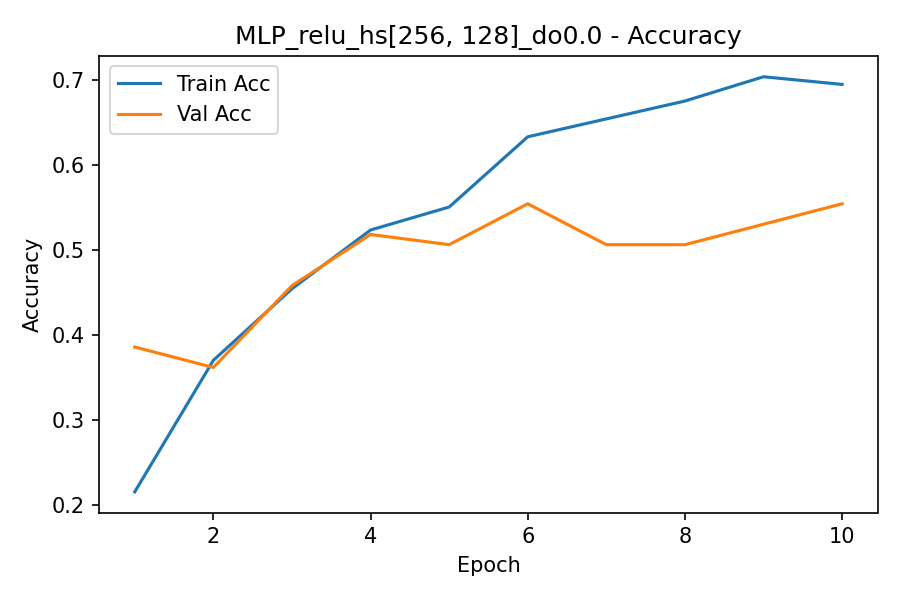

 - outputs/MLP_relu_hs[256, 128]_do0.0_loss.png


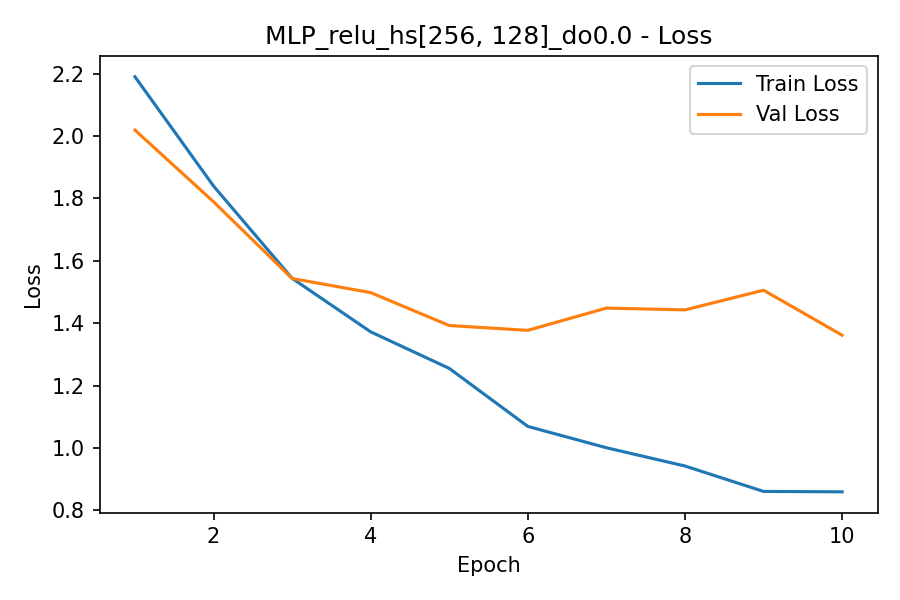

 - outputs/MLP_relu_hs[512, 256]_do0.0_acc.png


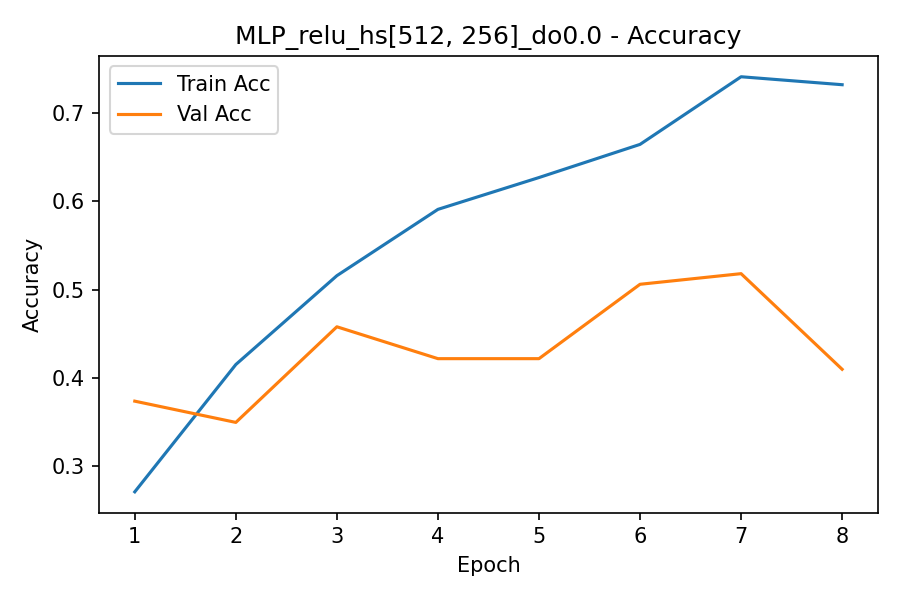

 - outputs/MLP_relu_hs[512, 256]_do0.0_cm.png


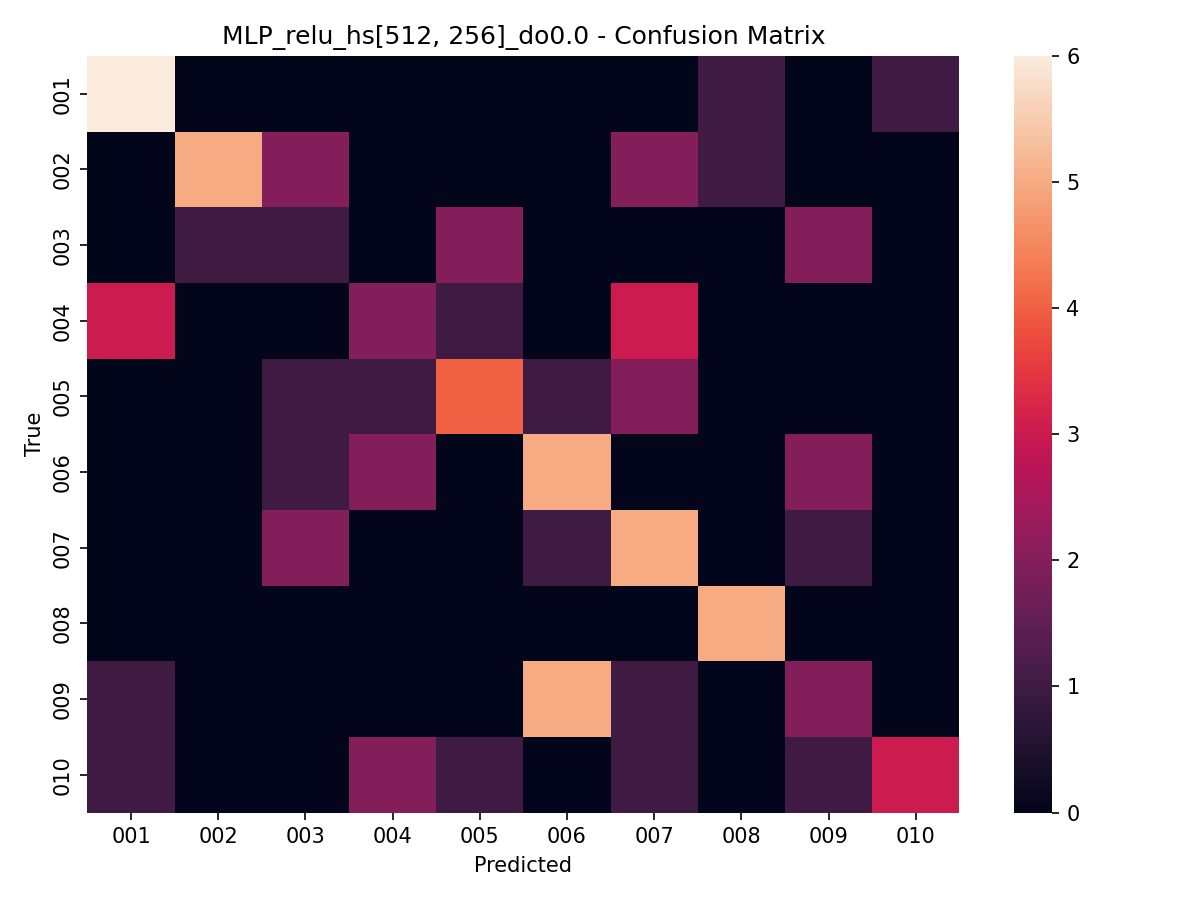

 - outputs/MLP_relu_hs[512, 256]_do0.0_loss.png


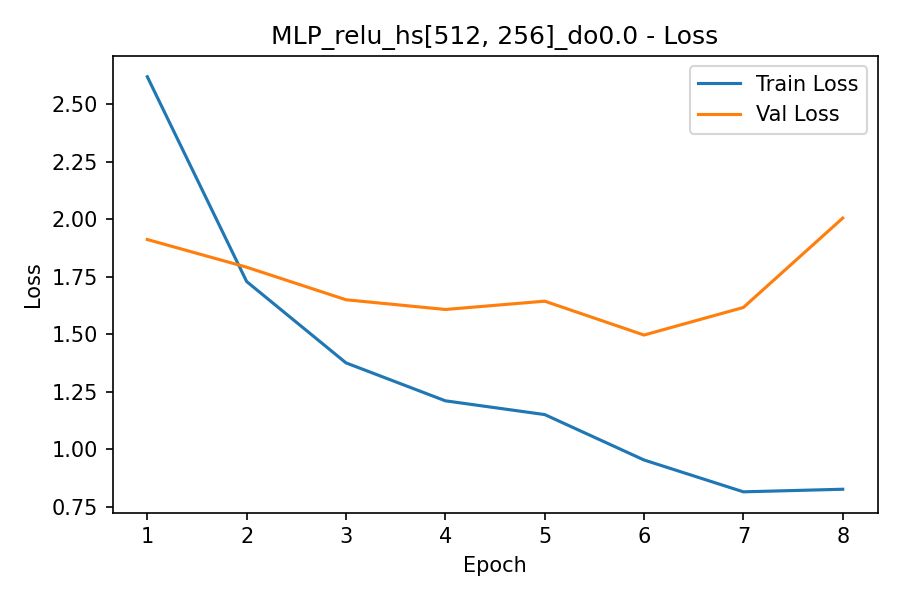

 - outputs/SimpleCNN_acc.png


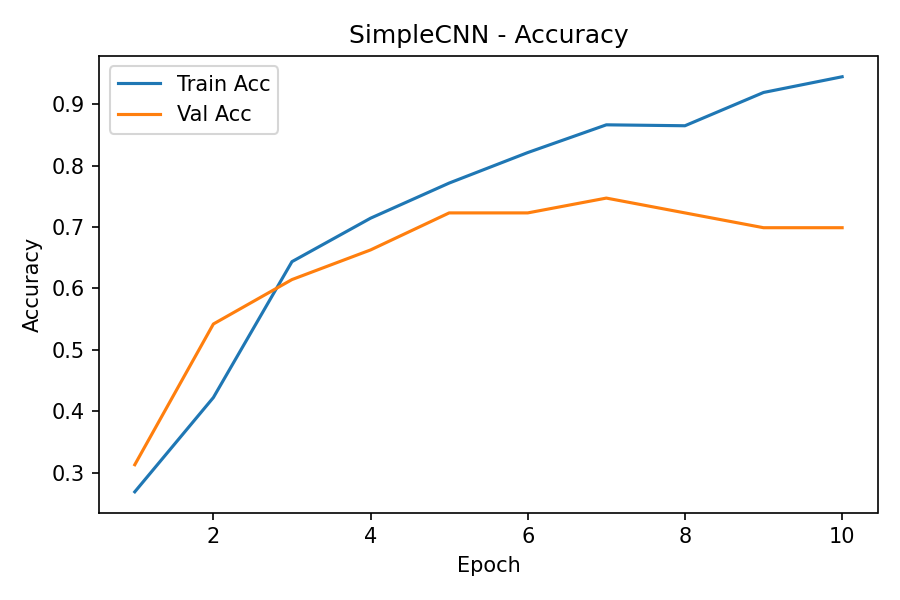

 - outputs/SimpleCNN_cm.png


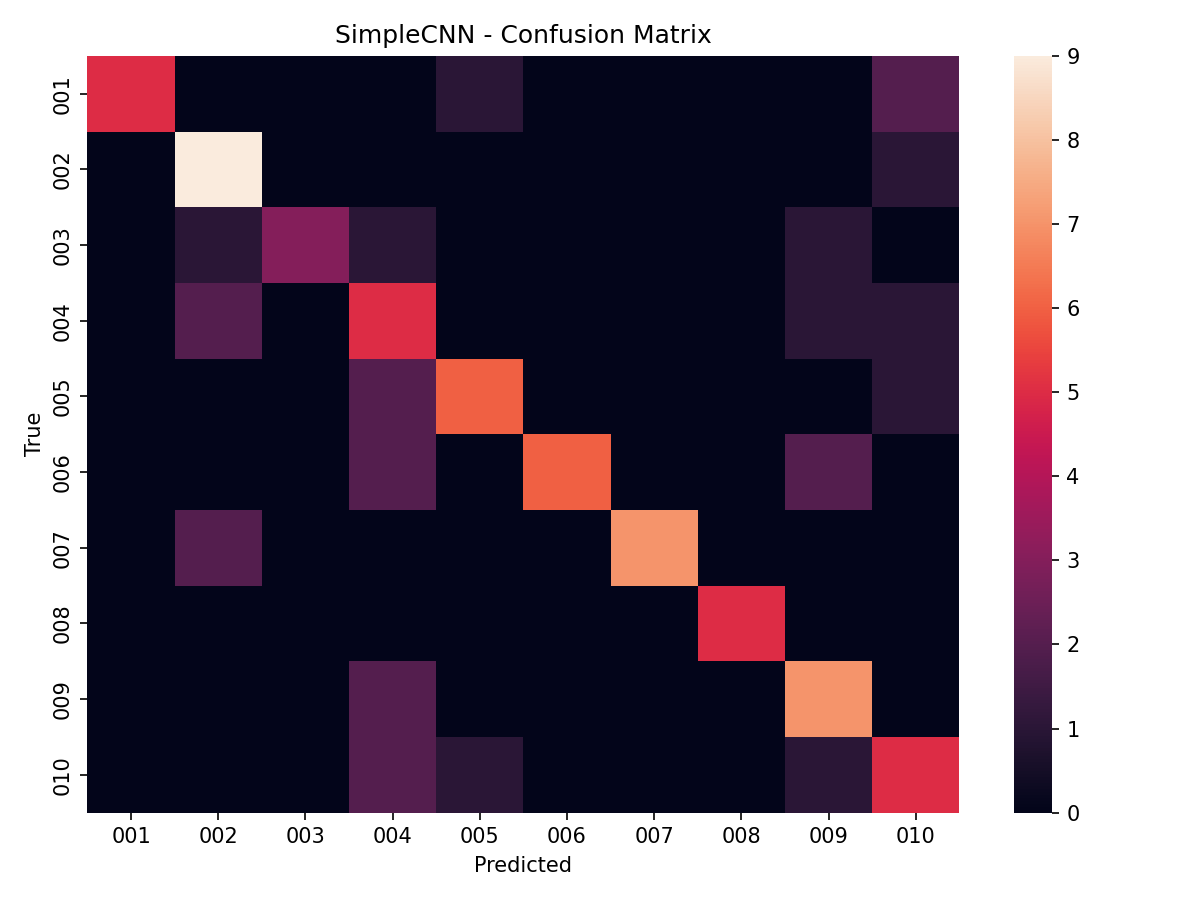

 - outputs/SimpleCNN_loss.png


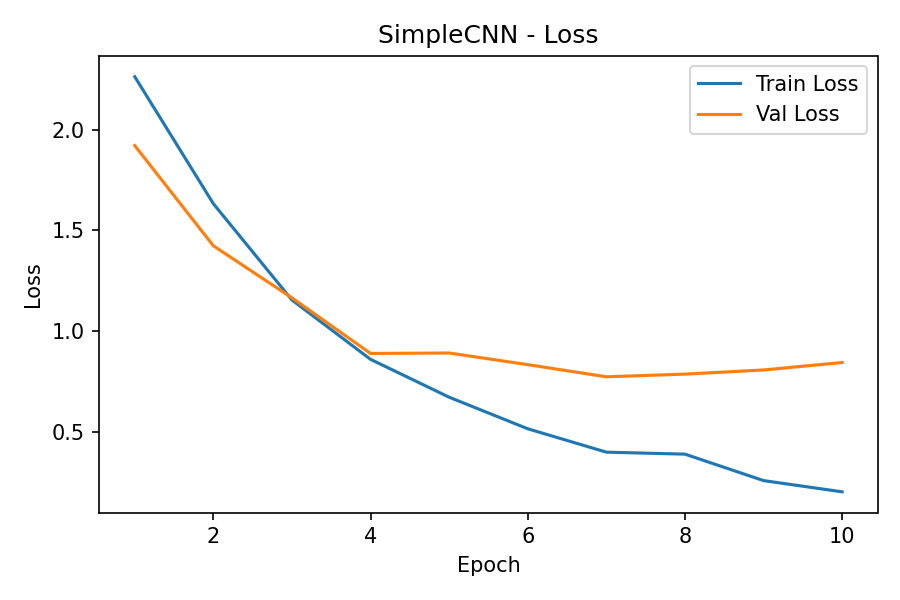


Reporte MLP (mejor):

Reporte: outputs/MLP_relu_hs[256, 128]_do0.0_classification_report.csv


,001,002,003,004,005,006,007,008,009,010,accuracy,macro avg,weighted avg
precision,0.454545,0.6,0.500000,0.400000,0.600000,0.777778,0.777778,0.833333,1.000000,0.466667,0.619048,0.641010,0.640248
recall,0.625000,0.6,0.333333,0.222222,0.666667,0.700000,0.777778,1.000000,0.555556,0.777778,0.619048,0.625833,0.619048
f1-score,0.526316,0.6,0.400000,0.285714,0.631579,0.736842,0.777778,0.909091,0.714286,0.583333,0.619048,0.616494,0.612603
support,8.000000,10.0,6.000000,9.000000,9.000000,10.000000,9.000000,5.000000,9.000000,9.000000,0.619048,84.000000,84.000000



Reporte CNN (mejor):

Reporte: outputs/SimpleCNN_classification_report.csv


,001,002,003,004,005,006,007,008,009,010,accuracy,macro avg,weighted avg
precision,1.000000,0.642857,1.000000,0.357143,0.750000,1.00,1.000000,1.0,0.583333,0.500000,0.690476,0.783333,0.763605
recall,0.625000,0.900000,0.500000,0.555556,0.666667,0.60,0.777778,1.0,0.777778,0.555556,0.690476,0.695833,0.690476
f1-score,0.769231,0.750000,0.666667,0.434783,0.705882,0.75,0.875000,1.0,0.666667,0.526316,0.690476,0.714454,0.702758
support,8.000000,10.000000,6.000000,9.000000,9.000000,10.00,9.000000,5.0,9.000000,9.000000,0.690476,84.000000,84.000000


In [48]:
# ========================================================
# 7. Visualización de artefactos guardados (curvas + reports)
# ========================================================
import os, glob
from IPython.display import Image, display
import pandas as pd

print("Imágenes guardadas en outputs/:")
imgs = sorted(glob.glob("outputs/*.png"))
if imgs:
    for img in imgs:
        print(" -", img)
        display(Image(filename=img))
else:
    print(" (no hay PNGs — ejecuta la Celda 6 con save_artifacts=True en los mejores)")

def show_report(prefix):
    csv_path = f"outputs/{prefix}_classification_report.csv"
    if os.path.exists(csv_path):
        print("\nReporte:", csv_path)
        df = pd.read_csv(csv_path, index_col=0)
        display(df)
    else:
        print("\nNo se encontró:", csv_path)

# Usa los prefijos de la celda anterior:
print("\nReporte MLP (mejor):")
show_report(best_title_mlp)

print("\nReporte CNN (mejor):")
show_report(best_title_cnn)
